In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, get_indices
from model import LBPModel, CNNModel
from loss import LBPloss
from visualize import visualize

from tqdm import tqdm
from resnet import resnet18, resnet12



In [2]:
df = pd.read_csv('../data/df.csv')
print(df.shape)
df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('path')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

train_list = [get_data(img_id) for img_id in df.path.unique()]
print(len(train_list))
# df.head()

train_list[0]

(1555, 12)
1214


{'image_id': 'patch_images/2021.01.08/LBC141-20210105(1)/LBC141-20210105(1)_1001.png',
 'boxes': array([[1558., 1603.,   96.,   73.,    0.],
        [1452., 1263.,   82.,   94.,    0.]])}

In [3]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]

test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [4]:
BATCH_SIZE = 8
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [5]:
image, cell_iou, targets, path = next(iter(train_loader))
print(image.shape)
print(cell_iou.shape)
print(targets.shape)

torch.Size([8, 2048, 2048, 3])
torch.Size([8, 3721, 1])
torch.Size([8, 3721, 1])


In [6]:
device = torch.device('cuda')
# model = CNNModel().to(device)
model = resnet12(pretrained=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [7]:
epochs = 10
for epoch in (range(epochs)) :
    batch_losses = []
    loop = tqdm(train_loader, leave=True)
    for images, iou, targets, path in loop :

        batch_size, gride_size, _ = iou.shape
        images = images.permute(0,3,1,2).to(device)

        indices, iou, targets = get_indices(iou, targets)
        labels = torch.cat([iou, targets], dim=-1)
        labels = labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images, indices)
            loss, cell_loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        scaler.step(optimizer)
        scaler.update()        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
        batch_losses.append(loss.item())

        mean_loss = sum(batch_losses) / len(batch_losses)
        loop.set_postfix(loss=mean_loss) 


100%|██████████| 152/152 [00:53<00:00,  2.85it/s, loss=3.02]


In [8]:
indices

tensor([ 258,  654, 1206, 1267, 1713, 2005, 2031, 2145, 2303, 2391, 2407, 2508,
        2619, 2754, 3581])

In [9]:
saved_model = '../trained_models/model_v1.pt'
torch.save(model.state_dict(), saved_model)

In [10]:
saved_model = '../trained_models/model_v1.pt'
device = torch.device('cuda')
model = resnet12(pretrained=False).to(device)
model.load_state_dict(torch.load(saved_model))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# images, _, _ = next(iter(test_loader))
images, cell_iou, targets , path = next(iter(train_loader))
# images, cell_iou, targets , path = next(iter(test_loader))
print(images.shape)
# print(cell_iou.shape)
batch_size, seq_len, _ = cell_iou.shape
indices = torch.arange(start=0,end=seq_len,step=1)
images = images.permute(0,3,1,2).to(device)
# image = image.to(device)
with torch.no_grad():
    outputs = model(images, indices)

torch.Size([8, 2048, 2048, 3])


In [12]:
# print(outputs.shape)
# iou[0] > 0.8

In [13]:
# (outputs.view(2,15,15,2)[1,:,:,0] >= 0.999).sum()
grid_size = 61
print((outputs.view(BATCH_SIZE,grid_size,grid_size,2)[1,:,:,0] > 0.9).sum() )
print((outputs.view(BATCH_SIZE,grid_size,grid_size,2)[1,:,:,1] > 0.9).sum() )
print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,2)[0,:,:,1]))
print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,2)[1,:,:,1]))
print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,2)[2,:,:,1]))


tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0.4583, device='cuda:0')
tensor(0.4585, device='cuda:0')
tensor(0.4578, device='cuda:0')


In [14]:
outputs.view(BATCH_SIZE,grid_size,grid_size,2).shape

torch.Size([8, 61, 61, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59
(2048, 2048, 3)


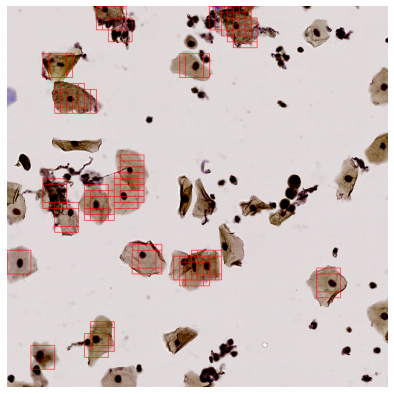

In [25]:
IMAGE_NUM=1
# normal cell
# a, b = (outputs.view(BATCH_SIZE,grid_size,grid_size,2)[IMAGE_NUM,:,:,0] >= 0.8).cpu().detach().nonzero(as_tuple=True)

# abnormal cell
a, b = (outputs.view(BATCH_SIZE,grid_size,grid_size,2)[IMAGE_NUM,:,:,1] >= 0.45).cpu().detach().nonzero(as_tuple=True)
# a, b = (iou.view(BATCH_SIZE,15,15)[0,:,:] >= 0.7).cpu().detach().nonzero(as_tuple=True)
bboxes = []

kernel_size = 128
stride = 32
for x, y in zip(a, b) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))

visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)

<class 'numpy.ndarray'>
(2048, 2048, 3)


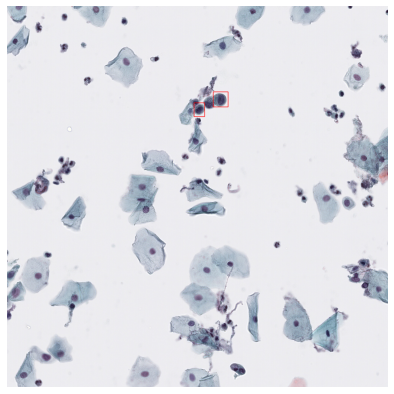

In [26]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'
train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])

In [17]:
img_path

'patch_images/2021.01.12/LBC311-20210108(1)/LBC311-20210108(1)_226.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


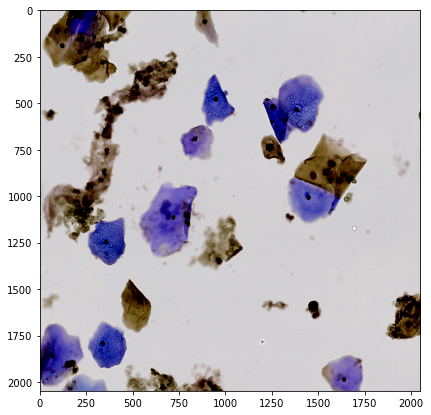

In [18]:

plt.figure(figsize=(7, 7))
plt.imshow(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy())